### Convex Adjustment:Q Theory 
$$
V(A,K)=\max_{0\leq K'\leq AK^\alpha+(1-\delta)K}\{AK^\alpha-\frac{\gamma}{2}(\frac{K'-(1-\delta)K}{K})^2K-p(K'-(1-\delta)K)+\beta E_{A'|A}V(A',K')\}\\
s.t. \ A' = \rho A +\epsilon
$$
### Nonconvex Adjustment
$$
V(A,K)=\max\{V^a(A,K),V^i(A,K)\}\\
V^a(A,K)=\max_{0\leq K'\leq AK^\alpha+(1-\delta)K}\{AK^\alpha-FK-p(K'-(1-\delta)K)+\beta E_{A'|A}V(A',K')\}\\
V^i(A,K)=AK^\alpha+\beta E_{A'|A}V(A',(1-\delta)K)\\
s.t. \ A' = \rho A +\epsilon
$$
### Mixed model
$$
V^b(A,K)=\max_{(1-\delta)K\leq K'\leq AK^\alpha+(1-\delta)K}\{AK^\alpha-FK-\frac{\gamma}{2}(\frac{K'-(1-\delta)K}{K})^2K-p(K'-(1-\delta)K)+\beta E_{A'|A}V(A',K')\}\\
V^s(A,K)=\max_{0\leq K'\leq (1-\delta)K}\{AK^\alpha-FK-\frac{\gamma}{2}(\frac{(1-\delta)K-K'}{K})^2K+p_s((1-\delta)K-K')+\beta E_{A'|A}V(A',K')\}\\
V^i(A,K)=AK^\alpha+\beta E_{A'|A}V(A',(1-\delta)K)\\
s.t. \ A' = \rho A +\epsilon
$$

In [1]:
%matplotlib inline
from __future__ import division
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.optimize import fminbound
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
import random as rd
from scipy.optimize import bisect


In [2]:
class Investment(object):
    def __init__(self, beta=0.95, delta = 0.069, gamma = 0.043, alpha = 0.51,p = 1,F = 0.00039,ps = 0.967,
                     transition = [[.5,.5],[.5,.5]], shocks = [.9, 1.1],grid_max=50,
                     grid_min = .1, grid_size=200):

        self.delta, self.beta, self.gamma,self.alpha,self.p,self.F,self.ps = delta, beta, gamma,alpha,p,F,ps
        self.shocks = shocks
        self.transition = np.asarray(transition)

        self.grid = np.linspace(grid_min, grid_max, grid_size)

        if len(self.transition) != len(self.shocks):
            self.transition = [[1/len(self.shocks)]*len(self.shocks)]*len(self.shocks)

        for j in range(len(self.transition)):
            self.transition[j] = [max(k, 0) for k in self.transition[j]]
            self.transition[j] /= np.asarray(list(self.transition[j])).sum()
            if np.asarray(self.transition[j]).sum() == 0:
                self.transition[j] = np.asarray([1/len(self.transition)]*len(self.transition))
        self.transition = np.asarray(self.transition)

    def bellman_operator(self, w):

        Aw = [InterpolatedUnivariateSpline(self.grid, w[i]) for i in range(len(self.shocks))]
        Awx = lambda y: np.asarray([function(y) for function in Aw])
        sigma = np.asarray([np.empty(len(w[0]))]*len(self.shocks))
        Tw = np.asarray([np.empty(len(w[0]))]*len(self.shocks))
        flag = np.asarray([np.empty(len(w[0]))]*len(self.shocks))
        for i, x in enumerate(self.grid):
            for j, e in enumerate(self.shocks):
                buy = lambda k: -e*x**self.alpha+self.F*x+self.gamma*x*(k/x-1+self.delta)**2/2+self.p*(k-(1-self.delta)*x)-self.beta*np.dot(self.transition[j],Awx(k))
                sell = lambda k: -e*x**self.alpha+self.F*x+self.gamma*x*(-k/x+1-self.delta)**2/2-self.ps*(-k+(1-self.delta)*x)-self.beta*np.dot(self.transition[j],Awx(k))
                inaction = e*x**self.alpha+self.beta*np.dot(self.transition[j],Awx((1-self.delta)*x))
                b_star = fminbound(buy,(1-self.delta)*x,(1-self.delta)*x+e*x**self.alpha)
                s_star = fminbound(sell,0,(1-self.delta)*x)
                buy_max = -buy(b_star)
                sell_max = -sell(s_star)
#                 print( buy_max,sell_max,inaction)
                Tw[j][i] =  max(buy_max,sell_max,inaction)
                if Tw[j][i] == buy_max:
                    sigma[j][i] = b_star
                    flag[j][i] = 1
                elif Tw[j][i] == sell_max:
                    sigma[j][i] = s_star
                    flag[j][i] = -1
                else:
                    sigma[j][i] = (1-self.delta)*x
                    flag[j][i] = 0
        return Tw, sigma,flag
    
        
    
 

In [3]:
def approx_markov(rho, sigma_u, m, n):
        F = norm(loc=0, scale=sigma_u).cdf


        std_y = np.sqrt(sigma_u**2 / (1-rho**2))
        x_max = m * std_y
        x_min = - x_max
        x = np.linspace(x_min, x_max, n)

        step = (x_max - x_min) / (n - 1)
        half_step = 0.5 * step
        P = np.empty((n, n))

        for i in range(n):
            P[i, 0] = F(x[0]-rho * x[i] + half_step)
            P[i, n-1] = 1 - F(x[n-1] - rho * x[i] - half_step)
            for j in range(1, n-1):
                z = x[j] - rho * x[i]
                P[i, j] = F(z + half_step) - F(z - half_step)

        return x, P

In [4]:
def compute_fixed_point(T, v, error_tol=1e-3, max_iter=500,
                            print_skip=25,verbose=True):#迭代计算
        i = 0
        error = error_tol + 1

        while i < max_iter and error > error_tol:
            new_v = T(v)[0]
            i += 1
            error = np.max(np.abs(new_v - v))
            if verbose and i % print_skip == 0:
                print(f"第 {i}步收敛结果是  {error}.")
                
            v = new_v
        if i == max_iter:
            print("收敛失败")
        if verbose and i < max_iter:
            print(f"\n在第 {i} 步收敛")


        return v

In [5]:
epsilon, trans = approx_markov(rho = .106, sigma_u=.855, n = 3, m=0.6)
shocklist = np.exp(epsilon)

print(trans,shocklist)

[[0.40604161 0.23664902 0.35730937]
 [0.38144048 0.23711903 0.38144048]
 [0.35730937 0.23664902 0.40604161]] [0.59695918 1.         1.67515643]


In [6]:
%%time
cp = Investment(transition=trans,shocks=shocklist)
# w_guess = np.asarray([np.log(cp.grid)]*len(cp.shocks))
w_guess = np.zeros((len(cp.shocks),len(cp.grid)))
# w_guess

w_star = compute_fixed_point(cp.bellman_operator, w_guess, max_iter=500, verbose=1, error_tol=1e-3, print_skip=10)


第 10步收敛结果是  1.7281890870825691.
第 20步收敛结果是  1.0203991012406988.
第 30步收敛结果是  0.6109049697721787.
第 40步收敛结果是  0.3657708697055142.
第 50步收敛结果是  0.21900052555535865.
第 60步收敛结果是  0.1311237043057929.
第 70步收敛结果是  0.07850860537715221.
第 80步收敛结果是  0.047006002087428556.
第 90步收敛结果是  0.028144229815694644.
第 100步收敛结果是  0.01685099001707613.
第 110步收敛结果是  0.010089310185989575.
第 120步收敛结果是  0.006040842699832183.
第 130步收敛结果是  0.0036168756685270864.
第 140步收敛结果是  0.002165557067399959.
第 150步收敛结果是  0.0012965990102884462.

在第 156 步收敛
Wall time: 12min 15s


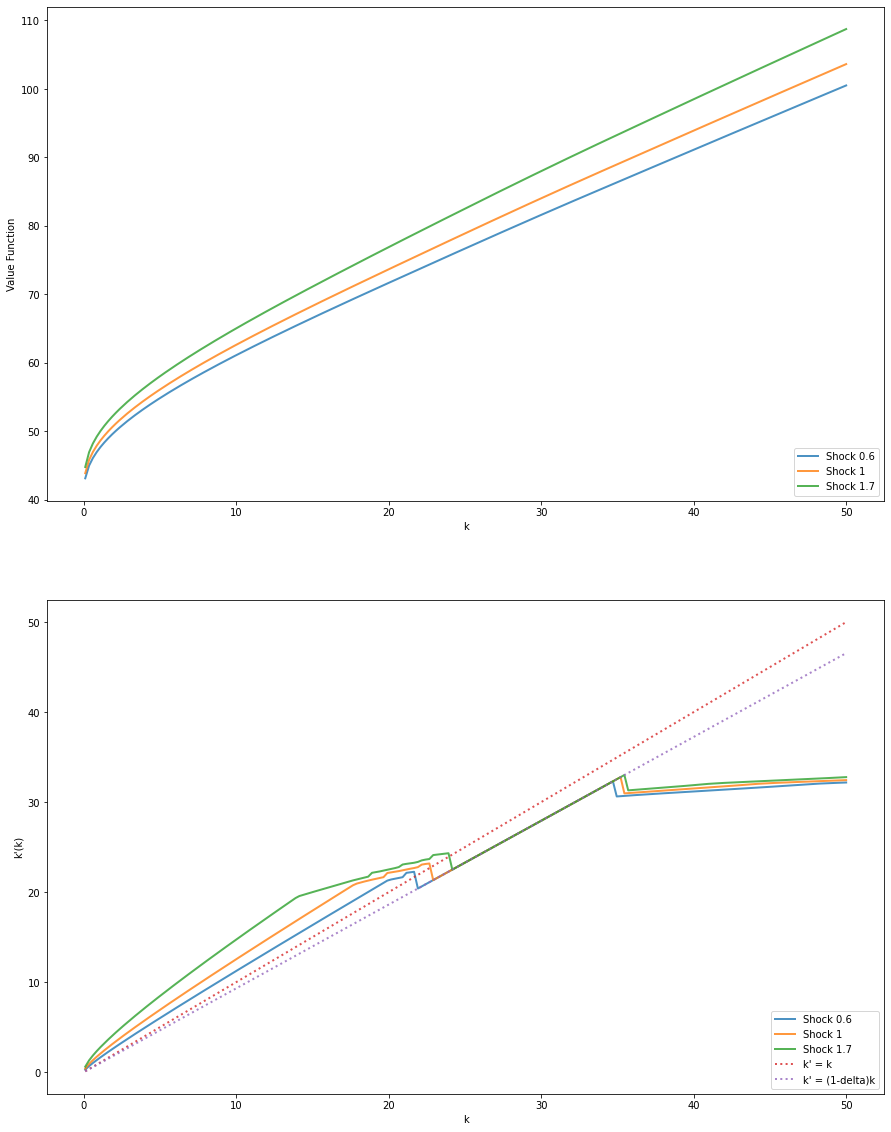

In [7]:
sigma_star = cp.bellman_operator(w_star)[1]
flag_star = cp.bellman_operator(w_star)[2]


fig, ax = plt.subplots(2, 1, figsize =(15,20))
ax[0].set_xlabel("k")
ax[1].set_xlabel("k")

ax[0].set_ylabel("Value Function")
ax[1].set_ylabel("k'(k)")



#         ax[0].set_prop_cycle(cycler('r', 'g', 'b', 'c', 'm', 'y')
labels = [r'Shock {0:.2g}'.format(cp.shocks[k]) for k in range(len(cp.shocks))] # Label "Shock 1", "Shock 2"
for i in range(len(cp.shocks)):
    ax[0].plot(cp.grid, w_star[i], lw = 2, alpha = .8, label= labels[i])
for i in range(len(cp.shocks)):
    ax[1].plot(cp.grid, sigma_star[i], alpha = .8, lw = 2,  label= labels[i])

ax[1].plot(cp.grid,cp.grid, alpha = .8, lw = 2,  label= "k' = k",linestyle=":")
ax[1].plot(cp.grid,(1-cp.delta)*cp.grid, alpha = .8, lw = 2,  label= "k' = (1-delta)k",linestyle=":")

ax[0].legend(loc = 'lower right')
ax[1].legend(loc = 'lower right')

plt.show()

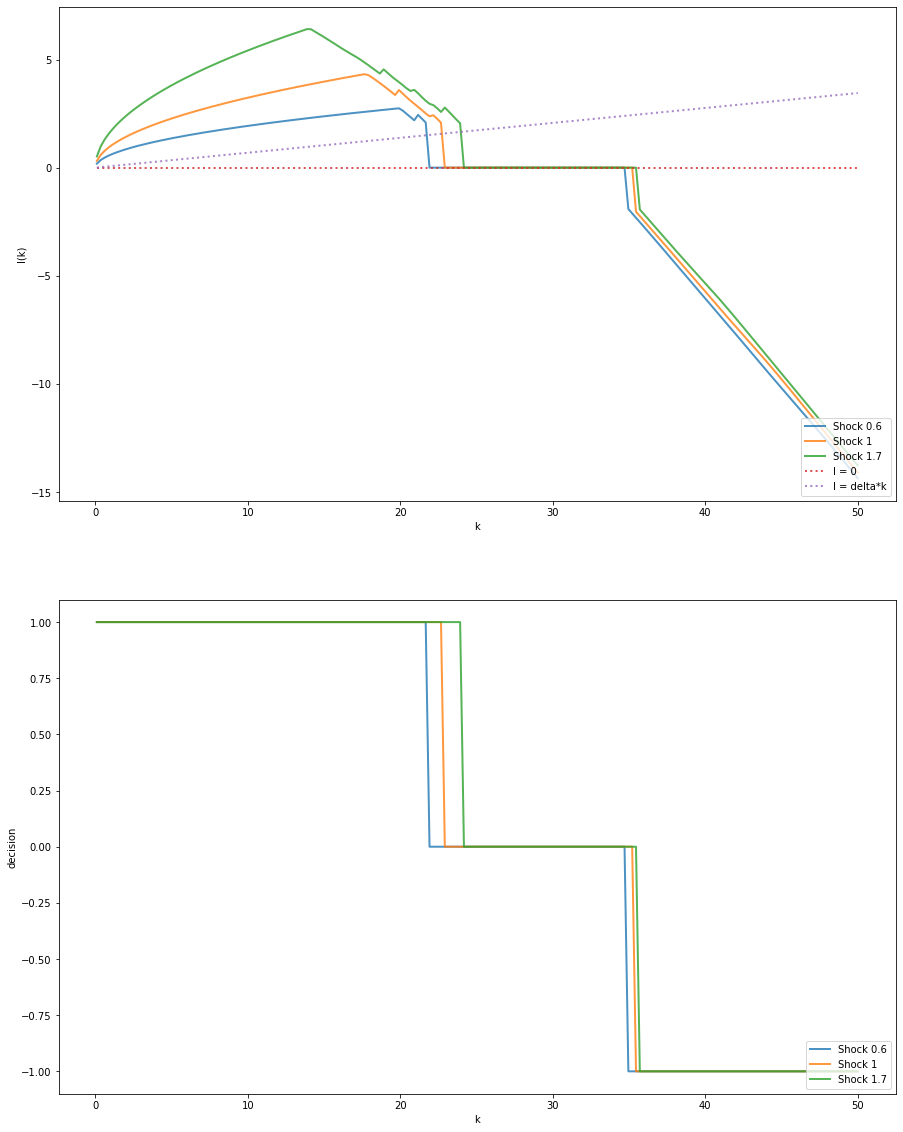

In [8]:
fig, ax = plt.subplots(2, 1, figsize =(15,20))

ax[0].set_xlabel("k")
ax[1].set_xlabel("k")
ax[0].set_ylabel("I(k)")
ax[1].set_ylabel("decision")


#   ax[0].set_prop_cycle(cycler('r', 'g', 'b', 'c', 'm', 'y')
labels = [r'Shock {0:.2g}'.format(cp.shocks[k]) for k in range(len(cp.shocks))] # Label "Shock 1", "Shock 2"

for i in range(len(cp.shocks)):
    ax[0].plot(cp.grid, sigma_star[i]-(1-cp.delta)*cp.grid, alpha = .8, lw = 2,  label= labels[i])    
for i in range(len(cp.shocks)):
    ax[1].plot(cp.grid, flag_star[i], alpha = .8, lw = 2,  label= labels[i])

ax[0].plot(cp.grid,np.zeros(len(cp.grid)), alpha = .8, lw = 2,  label= "I = 0",linestyle=":")
ax[0].plot(cp.grid,cp.delta*(cp.grid), alpha = .8, lw = 2,  label= "I = delta*k",linestyle=":")
ax[0].legend(loc = 'lower right')
ax[1].legend(loc = 'lower right')
plt.show()

In [15]:
def simulation(cp,sigma_star,cap,n,a,b):

    sigma = [InterpolatedUnivariateSpline(cp.grid,sigma_star[i] ) for i in range(len(cp.shocks))]
    stable = np.empty(len(cp.shocks))

    for i in range(len(cp.shocks)):
        f = lambda k: sigma[i](k)-k
        stable[i] = bisect(f,a,b)

    kk = np.zeros(n+1)
    inv = np.zeros(n)
    ii = np.zeros(n)
    state = np.zeros(n+1)
    ident = np.array(trans)
    for i in range (0,3):
        for j in range (1,3):
            ident[i][j] = trans[i][j] + ident[i][j-1]
    state[0] = 1
    kk[0] = cap
    for i in range(0,n):
        flag = rd.random()
        for j in range(0,3):
            if flag < ident[int(state[i])][j]:
                kk[i+1] = sigma[j](kk[i])
                state[i+1] = j
                break

        inv[i]=kk[i+1]-(1-cp.delta)*kk[i]
        ii[i] = inv[i]/kk[i]
    
    
    fig, ax = plt.subplots(3, 1, figsize =(15,30))

    ax[0].set_xlabel("t")
    ax[1].set_xlabel("t")
    ax[2].set_xlabel("t")
    ax[0].set_ylabel("K")
    ax[1].set_ylabel("investment rate")
    ax[2].set_ylabel("state")

    labels = [r'Stable = {0:.2f}'.format(stable[k]) for k in range(len(cp.shocks))] # Label "Shock 1", "Shock 2"
    ax[0].plot(np.arange(0,n+1),kk, alpha = .8, lw = 2,)
    for i in range(len(cp.shocks)):
        ax[0].plot(np.arange(0,n), stable[i]*np.ones(n), alpha = .8, lw = 2,  label= labels[i],linestyle = ":") 
    ax[1].plot(np.arange(0,n),ii, alpha = .8, lw = 2)
    ax[2].plot(np.arange(0,n+1),state, alpha = .8, lw = 2)
    ax[0].legend(loc = 'lower right')
#     ax[1].legend(loc = 'lower right')
#     ax[2].legend(loc = 'lower right')
    plt.show()
    
#     return kk,ii,inv
            




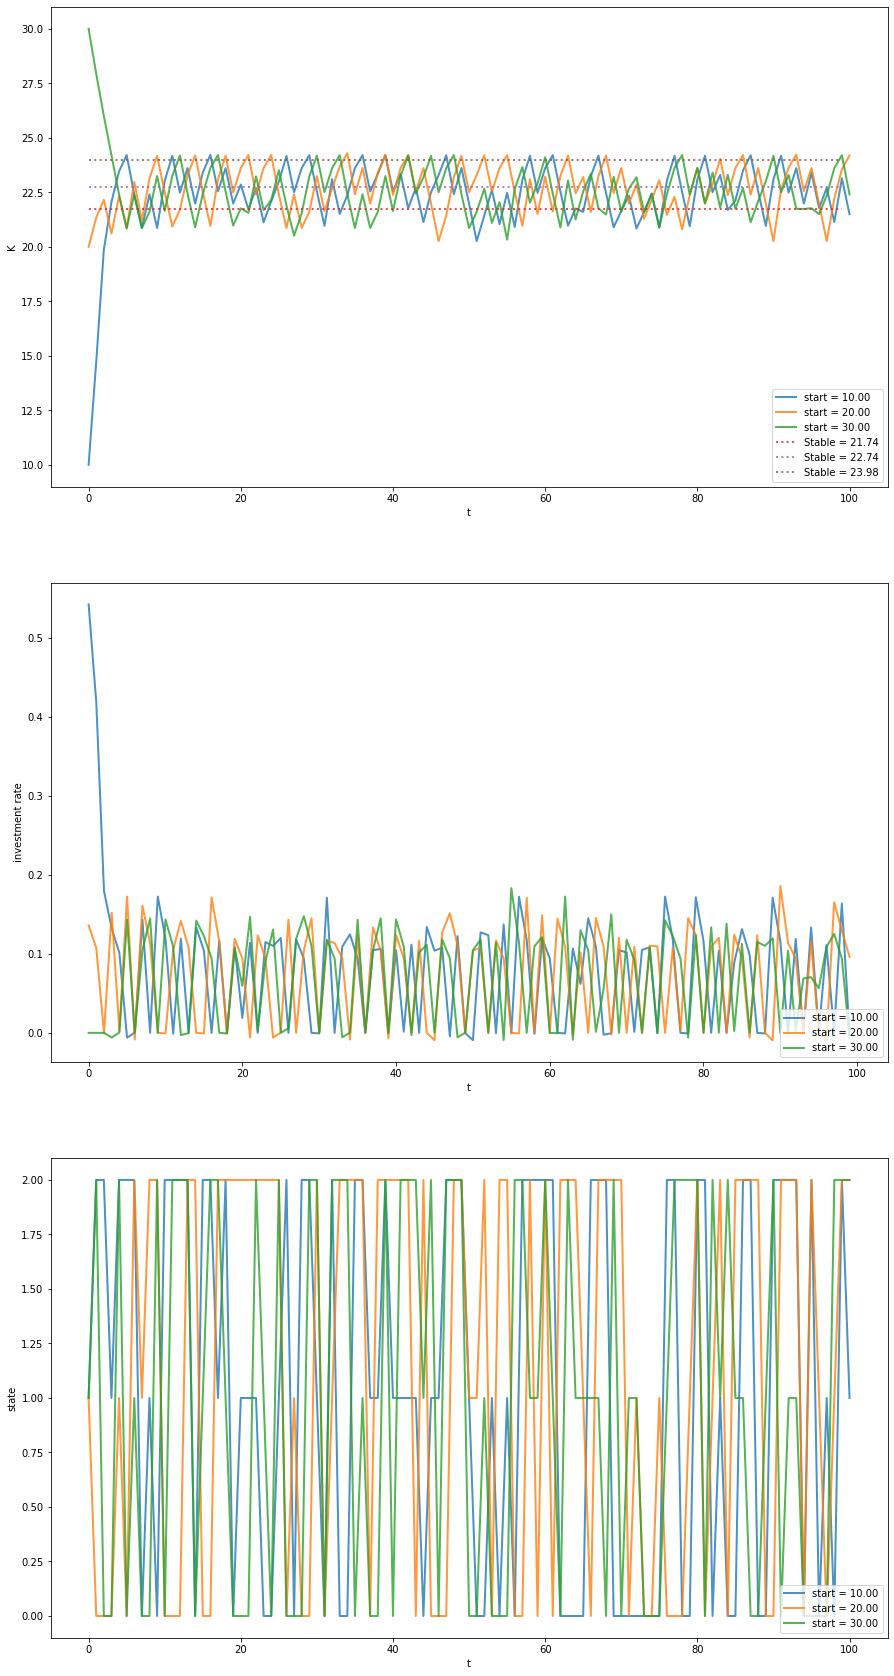

In [17]:
simulation(cp,sigma_star,(10,20,30),100,10,30)


In [14]:
# flag2 = cp.bellman_operator(w_star)[2]
# true_stable = np.empty([3,2])
# for j in range(0,3):
#     for i in range(0,200):
#         if(flag2[j][i] == 0):
#             true_stable[j][0] = sigma_star[j][i]
#             true_stable[j][1] = sigma_star[j][i-1]
#             print(j,cp.grid[i],sigma_star[j][i],sigma_star[j][i-1])
#             break
# cp.grid

array([ 0.1       ,  0.35075377,  0.60150754,  0.85226131,  1.10301508,
        1.35376884,  1.60452261,  1.85527638,  2.10603015,  2.35678392,
        2.60753769,  2.85829146,  3.10904523,  3.35979899,  3.61055276,
        3.86130653,  4.1120603 ,  4.36281407,  4.61356784,  4.86432161,
        5.11507538,  5.36582915,  5.61658291,  5.86733668,  6.11809045,
        6.36884422,  6.61959799,  6.87035176,  7.12110553,  7.3718593 ,
        7.62261307,  7.87336683,  8.1241206 ,  8.37487437,  8.62562814,
        8.87638191,  9.12713568,  9.37788945,  9.62864322,  9.87939698,
       10.13015075, 10.38090452, 10.63165829, 10.88241206, 11.13316583,
       11.3839196 , 11.63467337, 11.88542714, 12.1361809 , 12.38693467,
       12.63768844, 12.88844221, 13.13919598, 13.38994975, 13.64070352,
       13.89145729, 14.14221106, 14.39296482, 14.64371859, 14.89447236,
       15.14522613, 15.3959799 , 15.64673367, 15.89748744, 16.14824121,
       16.39899497, 16.64974874, 16.90050251, 17.15125628, 17.40